# Q learning with NumPy, Mountain Car

This notebook is implementing the basics of Q learning while creating the Q table from the ground up using NumPy. 
This notebook was built by following the instruction from the article wrttien by [Bradford Gill](https://medium.com/@bradfordgill/q-learning-with-numpy-mountain-car-feaef1c4ed1a). 

In [1]:
import numpy as np
from math import floor
import matplotlib.pyplot as plt
from celluloid import Camera

## Problem statement
The state space consists of two values, position and velocity. The allowed positions are in the between -1.2 and 0.6, with .6 being the goal. The velocity can exist between a range of -0.07 and 0.07. There are three actions accelerate in the negative direction, no velocity change, and accelerate in the positive direction. The staring position can be between -0.6 and 0.4. The velocity and state are updated by an equation seen in the Q_table class.

In [7]:
POSITION_SPACE = (-1.2, .6)
VELO_SPACE = (-.07, .07)
ACTION_SPACE = [-1, 0, 1]
START_RANGE = (-.6, -.4)

## Let build a Q Table class specific for this problem

Since tables can’t be infinite size, we must break the state space up into a discrete set of states. We will do this by hashing a state action pair to an index in the Q table, which is a NumPy ndarray. The Q table array will consist of position, velocity, and action dimensions whose lengths are specified as initialization parameters. The details of the class are in the comments, at a high level; the class will contain the Q table, a function to map states and actions to indexes, a function to get the next state given a state action pair, a function to update the Q value with the Bellman equation, and a few other utility functions that enable this to happen.

In [3]:
class Q_table():
    def __init__(self, discrete_ps = 30, discrete_vs = 30, discrete_as = 3):
        """
        discrete_ps: positon dim length 
        discrete_vs: velocity dim length 
        discrete_as: actions dim length 
        """
        self.p_len, self.v_len, self.a_len = discrete_ps, discrete_vs, discrete_as # store the size of each dimension
        self.table = np.zeros((discrete_ps, discrete_vs, discrete_as)) # create the Q table initialized to 0
        
        # create mappings from position, velocity, and action to indexes
        self.map_p_to_i = lambda p: floor((p - POSITION_SPACE[0])  / (POSITION_SPACE[1] - POSITION_SPACE[0]) * (discrete_ps - 1))
        self.map_v_to_i = lambda v: floor((v - VELO_SPACE[0])  / (VELO_SPACE[1] - VELO_SPACE[0]) * (discrete_vs - 1))
        self.map_a_to_i = lambda a: floor(a + 1)
        mappings = [self.map_p_to_i, self.map_v_to_i, self.map_a_to_i]
        self.map_pva_to_ijk = lambda p, v, a: [f(x) for x, f in zip([p, v, a], mappings)] # takes in p, v, and a returns the corresponding index 
        # this mapping may seem complicated but it limited my production time so I made the sacrifice 

    def get_value(self, p, v, a):
        i, j, k = self.map_pva_to_ijk(p, v, a) # return corresponding index to p, v, a
        return self.table[i, j, k]
    
    def get_random_action(self, *args): # args is included to allow p, v variables to be passed to function even though they are not need
        return np.random.choice(ACTION_SPACE) # return a random action from the action space

    def get_best_action(self, p, v): 
        return np.argmax(self.table[self.map_p_to_i(p), self.map_v_to_i(v), :]) - 1 # will return the best estimated action from [-1, 0, 1]

    def update_state(self, p, v, a):
        v += a  * 0.001 - np.cos(3 * p) * 0.0025 # update velocity 
        v = np.clip(v, *VELO_SPACE) # limit velocity to velocity space
        p += v # increment p
        if p < POSITION_SPACE[0] and v < 0: # if the agent is past the far left boundry and moving left
            p = POSITION_SPACE[0] # set position to left edge of pos space
            v = 0 # set velo = 0 
        return p, v

    def update_Q(self, reward, lr, discount, p, v, a): 
        """
        this updates the Q value based on the bellman equation: https://en.wikipedia.org/wiki/Bellman_equation
        """
        i, j, k = self.map_pva_to_ijk(p, v, a)  # self.mappings countian the mapping of p, v, a to an index, the zip returns a
        # tuple of a mapping function and a corresponding variable, 
        Q = self.table[i, j, k] 
        p_prime, v_prime = self.update_state(p, v, a) # tuple of new state
        i_prime, j_prime = self.map_pva_to_ijk(p_prime, v_prime, 0)[:2] # get the indexes corresponding to the next state
        i_prime, j_prime = min(self.p_len - 1, i_prime), min(self.v_len - 1, j_prime) # prevent the next state from being out of bounds
        # bellman eq: Qnew = Q + lr(reward + discount * best_action_est, - Q) 
        self.table[i, j, k] = Q + lr * (reward + discount * np.max(self.table[i_prime, j_prime, :]) - Q) # update Q value 


# Let's enable the simulation
The agent needs to explore the model and learn the value of actions given a state. 
There are multiple ways of doing this. One choice is to allow the model to search the environment until it reached the goal and iterate to the next episode as long as the simulation time was below a threshold. This often worked, but sometimes the agent would get stuck and run for millions of iterations. 
Alternatively, we can implement episodic tasks by only allowing 250 steps per episode, looping over a fixed number of episodes. The convergence on the second method was much faster.

When it comes to learning, we need to balance the exploration and exploitation. We will use the epsilon greedy method, also refereed to as e-greedy. Epsilon represents the probability of exploring, hence a large epsilon will take a random action to explore the model and a low epsilon will take the greedy action with the highest estimated reward. Generally, it is best to have a high epsilon at the beginning of the simulation and lower it as you go through the simulation. I defined epsilon as 1 initially, giving the agent a 100% chance of exploring randomly. As the simulation continues, epsilon will be decayed by e_decay_rate until it reaches the minimum value of .01.

The simulation does the following: before the loop, create an array to store the reward from each function, initialize the Q table, define epsilon, and the epsilon decay function. The outer for loop goes over a fixed number of episodes. At the beginning of each episode, the position will be initialized to a value within the start range, the velocity will start at 0, and the reward will be set to 0. The inner while loop goes through the model step by step until 250 steps have been taken or the agent reaches the goal position. During each step the action is chosen at random or by maximum predicted reward, the Q table is updated given a reward of -1 since the agent has not reached the goal value, the next state is calculated from the action, and the cumulative reward counter is incremented. After the while loop ends, the cumulative reward of the episode is stored in the rewards array at the appropriate index and epsilon is decayed.

In [4]:
def simulate(discount, lr, e_decay_rate, num_episodes = 5000, return_table = False, 
             epsilon_min = 0.01, episode_length = 250):
    rewards = np.zeros(num_episodes) # create an array of awards with an index for each episode
    Qt = Q_table() # init Q table 
    epsilon = 1 # prob of exploring, 1 - epsilon = prob of exploiting (best)
    e_decay = lambda e: max(e * e_decay_rate, epsilon_min) # how fast epsilon decays, the min value comes from deep minds paper
    for i in range(num_episodes): # loop over each episode 
        p, v = np.random.uniform(*START_RANGE), 0 # init p and v for the episode 
        reward = 0 # set reward counter to 0 
        while p < POSITION_SPACE[1] and reward < episode_length: # check if goal is reached and the episode isnt longer than episode_length 
            a_fn = np.random.choice([Qt.get_best_action, Qt.get_random_action], p = [1 - epsilon, epsilon]) # select exploiting function or exploring function 
            a = a_fn(p, v) # get approiate action
            Qt.update_Q(-1, lr, discount, p, v, a) # update Q table
            p, v = Qt.update_state(p, v, a) # get next state and action
            reward += 1 # incremnent reward 
        rewards[i] = reward # store reward of this episode in the corresponding index
        epsilon = e_decay(epsilon) # decay epsilon 
    if return_table:
        return rewards, Qt # return the table if requested, allows me live graph the process 
    else:
        return rewards

First, I am going to do a random search for the optimal parameters. This process and take a while, so feel free to skip this step and take my results. If you’re up to a challenge you can try to use [Bayesian Optimization](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html) instead of random search, it has been shown to be more effective.

In [5]:
def hyper_search():
    """
    Lets do some hyperparam search! I am using an interative random search method. I will do a few trails, see what hyper params work and dont work then from
    there iterate. 
    """
    """ outputs of the hyper param search 
    score: 211.72, discount: 0.2824933520659566, lr: 0.17244939592088193, epsilon_decay: 0.9422534370060514
    score: 221.968, discount: 0.449881569041625, lr: 0.2797153971134617, epsilon_decay: 0.5612766255280709
    score: 212.474, discount: 0.47365344896391615, lr: 0.34464527505672415, epsilon_decay: 0.7545763229312964
    score: 147.08, discount: 0.8941097749008459, lr: 0.281720165576596, epsilon_decay: 0.6402003793646793 these are the best found hyper params 
    score: 191.864, discount: 0.694823346681323, lr: 0.1975957805539046, epsilon_decay: 0.6081500458326561
    score: 223.624, discount: 0.5669016355520428, lr: 0.3532305508549993, epsilon_decay: 0.6683549632717782
    score: 193.684, discount: 0.9403139125426704, lr: 0.38720828795289886, epsilon_decay: 0.9810833438406337
    score: 175.858, discount: 0.4590723333145095, lr: 0.22499849644943165, epsilon_decay: 0.5712505297039662
    score: 183.182, discount: 0.4603140408915277, lr: 0.1298694973714855, epsilon_decay: 0.7293091177345252
    score: 250.0, discount: 0.15668291093964357, lr: 0.37399716877833344, epsilon_decay: 0.6667601971835406
    score: 189.818, discount: 0.9302288566529271, lr: 0.3461452836964455, epsilon_decay: 0.5225729267470409
    score: 206.89, discount: 0.7393388279997576, lr: 0.38404711840235606, epsilon_decay: 0.6978357947772437
    score: 250.0, discount: 0.13798033479312335, lr: 0.3941747862632219, epsilon_decay: 0.9399145331098893
    score: 198.196, discount: 0.7249406276042496, lr: 0.233962415206557, epsilon_decay: 0.65366939065216
    score: 222.288, discount: 0.18603651792662607, lr: 0.10025206638754855, epsilon_decay: 0.746878295600906
    score: 214.428, discount: 0.2933310640544758, lr: 0.11295598407531794, epsilon_decay: 0.9064368432918122
    score: 179.178, discount: 0.6077255751840971, lr: 0.1592095997311603, epsilon_decay: 0.7834561753174173
    score: 172.55, discount: 0.8588934763634241, lr: 0.11672460536562612, epsilon_decay: 0.700945100569841
    score: 231.534, discount: 0.6922898626050366, lr: 0.25278751556240864, epsilon_decay: 0.8105051350601509
    score: 248.862, discount: 0.1599106876760406, lr: 0.13941395688375366, epsilon_decay: 0.7350357615629758
    """
    trials = 20 # number of trials to do in search 
    scores = [] # array to keep track of the score of each trial 
    discount_range = (.1, 1.) # range that discount can be between 
    lr_range = (.1, .4) # range that lr can be between
    e_decay_range = (.5, 1.) # range that epsilon decay can be in 
    hp = {} # dict to store hyper params in 
    hp['discount'] = np.random.uniform(*discount_range, trials)
    hp['lr'] = np.random.uniform(*lr_range, trials)
    hp['epsilon_decay'] = np.random.uniform(*e_decay_range, trials)

    for i in range(trials): # for each trail
        hold = (hp['discount'][i], hp['lr'][i], hp['epsilon_decay'][i]) # tuple hold for func params
        score = simulate(*hold) # simulate with given hyper params
        scores.append(score) # append score to scores
        print("score: {}, discount: {}, lr: {}, epsilon_decay: {}".format(np.average(score[-500:]), *hold)) # print results 

    fig, axs = plt.subplots(3, 1) # create figure and 3 axes rows 
    for ax, key in zip(axs, hp.keys()): 
        ax.scatter(hp[key], np.average(scores[i])) # plot values for visual analysis 
        ax.set_title(key) # title graph 
    fig.show()

# hyper_search()

MovieWriter Pillow unavailable; using Pillow instead.


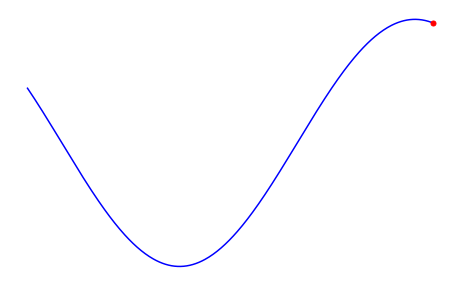

In [6]:
from IPython.display import HTML

def train_and_plot(lr, discount, epsilon_decay): # train the graph and show the 
    _, Qt = simulate(lr, discount, epsilon_decay, return_table = True) # get a Q table given hyper params 
    N = 400  
    x = np.linspace(*POSITION_SPACE, N) # linearly spaced array across the positon space with N indexes 
    fn = lambda x: np.sin(3*x) # function that turns x position to y value (makes the mountians)
    y = fn(x) # create y array 
    fig, ax = plt.subplots(1, 1, figsize = (8, 5)) # create a figure and axes
    camera = Camera(fig) # create the Camera for the animation 
    p, v = -.5, 0. # init and v 
    while p < POSITION_SPACE[1]: # run sim until 
        a = Qt.get_best_action(p, v) # get the best action given the state
        p, v = Qt.update_state(p, v, a) # update the state based on the action 
        ax.plot(x, y, c = 'b', zorder=0) # plot mounitans repeative but im not memory constrained so im not going to rewrite
        ax.scatter(p, fn(p), s = 25, c = 'r', zorder=5) # plot where the mountian car is, having a z order larger than the line specifies this will be on top
        ax.set_axis_off()
        camera.snap() # snap the frame 
    animation = camera.animate()
    HTML(animation.to_html5_video())
    animation.save('mountiancar.gif', writer='Pillow') # save the animation as a gif (located in this folder)
    
if __name__ == "__main__": # 
    train_and_plot(.894, .282, .640)